In [1]:
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import MinMaxScaler # Data normalization
from xgboost import XGBRegressor, DMatrix, plot_importance # XGBoost

In [3]:
# pip install tensorflow==2
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

/home/ipcvlab/anaconda2/envs/data_science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ipcvlab/anaconda2/envs/data_science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ipcvlab/anaconda2/envs/data_science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ipcvlab/anaconda2/e

In [4]:
df_train = pd.read_excel("/home/ipcvlab/Downloads/ilceler/yıllık-ilk-calısma/kadikoy_tum_veriler.xlsx", index_col = 0) 
cols_list = list(df_train.columns) 

In [5]:
df_train.head()

,HouseEndex,bist,USD/TRY,Aylık_Mevduat_Faizi,Konut_Kredisi,ic_borc_maliyet,tufe_endeks,guven_endeksi,kira endex
Tarih,,,,,,,,,
2007-06,100.00,47093.67,1.321548,17.588,18.0320,18.420723,139.69,80.949646,100.00
2007-07,99.91,52824.89,1.282132,17.520,17.4275,17.401225,138.67,82.270595,99.95
2007-08,100.10,50198.60,1.314595,17.452,17.1200,19.052940,138.70,85.024409,99.79
2007-09,100.60,54044.22,1.267385,17.335,17.5825,18.250570,140.13,83.885017,99.57
2007-10,101.10,57615.72,1.202367,16.905,17.2675,16.323523,142.67,82.975294,99.22


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, 2007-06 to 2019-12
Data columns (total 9 columns):
HouseEndex              151 non-null float64
bist                    151 non-null float64
USD/TRY                 151 non-null float64
Aylık_Mevduat_Faizi     151 non-null float64
Konut_Kredisi           151 non-null float64
ic_borc_maliyet         151 non-null float64
tufe_endeks             151 non-null float64
guven_endeksi           151 non-null float64
kira endex              151 non-null float64
dtypes: float64(9)
memory usage: 11.8+ KB


In [7]:
df_train.describe()

,HouseEndex,bist,USD/TRY,Aylık_Mevduat_Faizi,Konut_Kredisi,ic_borc_maliyet,tufe_endeks,guven_endeksi,kira endex
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,237.034238,71935.466291,2.589480,10.870206,13.967113,12.049846,244.453444,70.423582,168.883510
std,123.671282,22202.415236,1.381563,4.363666,3.984043,4.551850,80.716599,7.192777,62.669619
min,78.760000,24026.590000,1.176086,5.264000,8.297500,5.685006,138.670000,55.136536,88.670000
25%,100.850000,55799.800000,1.560281,7.537500,11.297500,8.949530,178.360000,65.648253,99.680000
50%,221.800000,73995.200000,1.993883,9.265000,12.868000,10.428706,223.910000,71.309231,170.800000
75%,371.000000,86107.350000,3.173407,12.277500,16.129000,14.648636,287.070000,75.903437,235.100000
max,394.200000,119528.790000,6.378340,22.852500,28.947500,25.808845,440.500000,85.024409,253.300000


### display Missing values

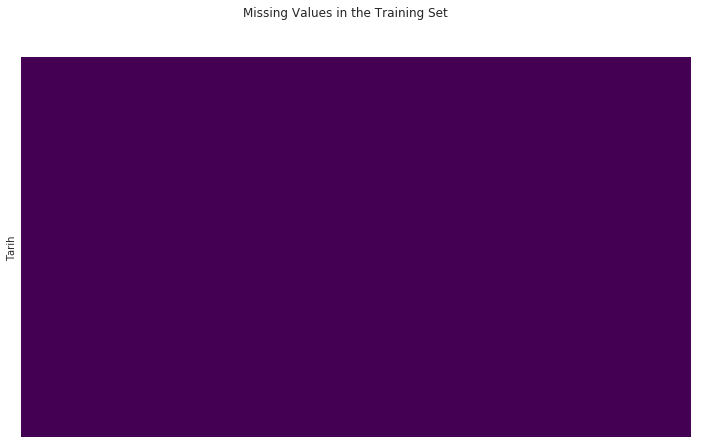

In [8]:
label_nas = []
for col in df_train.columns.tolist():
    if np.sum(df_train[col].isnull() ) != 0:
        label_nas.append(col)
    else:
        label_nas.append("")

plt.figure(figsize=(12,7))
plt.suptitle('Missing Values in the Training Set')
sns.heatmap(df_train.isnull(), yticklabels=False, xticklabels=label_nas ,cbar = False, cmap='viridis')
plt.show()

In [9]:
replace = True # True: replace null in guven_endeksi with average. False: guven_endeksi kullanmadan
if replace:
    df_train = df_train.fillna(df_train.mean())
else:
    df_train.drop('guven_endeksi', axis=1, inplace=True)

In [10]:
# Correlation matrix
corr_mat = df_train.corr().abs()
# Find most important features relative to target
corr_mat.sort_values(by=["HouseEndex"], ascending = False, inplace = True)
print(corr_mat.HouseEndex)

HouseEndex              1.000000
kira endex              0.994558
tufe_endeks             0.869316
bist                    0.858952
USD/TRY                 0.800112
guven_endeksi           0.397224
Aylık_Mevduat_Faizi     0.126331
ic_borc_maliyet         0.080751
Konut_Kredisi           0.032073
Name: HouseEndex, dtype: float64


In [11]:
#Correlation matrix between features
corr_mat = df_train.corr().abs()

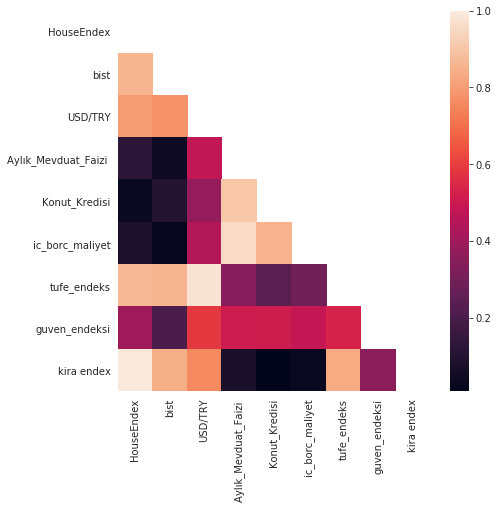

In [12]:
#Plot the heatmap with seaborn
plt.figure(figsize=(7,7)) 

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_mat, mask=mask,
        xticklabels=corr_mat.columns,
        yticklabels=corr_mat.columns)

In [13]:
#List the highly correlated columns
corr_tmp = corr_mat.unstack()
corr_tmp = corr_tmp.sort_values(kind="quicksort")

print(corr_tmp[-len(corr_mat)-10:-len(corr_mat)])

HouseEndex            tufe_endeks             0.869316
tufe_endeks           HouseEndex              0.869316
Konut_Kredisi         Aylık_Mevduat_Faizi     0.903588
Aylık_Mevduat_Faizi   Konut_Kredisi           0.903588
ic_borc_maliyet       Aylık_Mevduat_Faizi     0.954900
Aylık_Mevduat_Faizi   ic_borc_maliyet         0.954900
USD/TRY               tufe_endeks             0.978278
tufe_endeks           USD/TRY                 0.978278
kira endex            HouseEndex              0.994558
HouseEndex            kira endex              0.994558
dtype: float64


In [14]:
# Find most important features relative to target
corr_mat.sort_values(["HouseEndex"], ascending = False, inplace = True)
print(corr_mat.HouseEndex)

HouseEndex              1.000000
kira endex              0.994558
tufe_endeks             0.869316
bist                    0.858952
USD/TRY                 0.800112
guven_endeksi           0.397224
Aylık_Mevduat_Faizi     0.126331
ic_borc_maliyet         0.080751
Konut_Kredisi           0.032073
Name: HouseEndex, dtype: float64


# Skewness

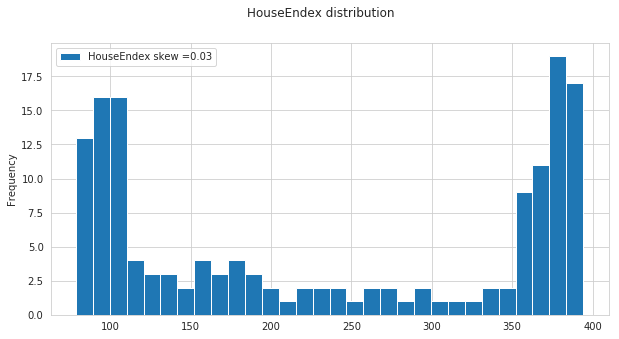

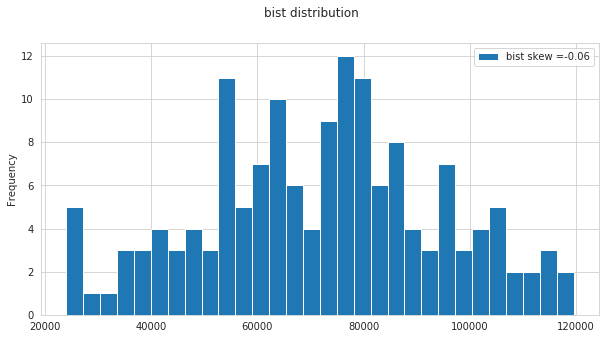

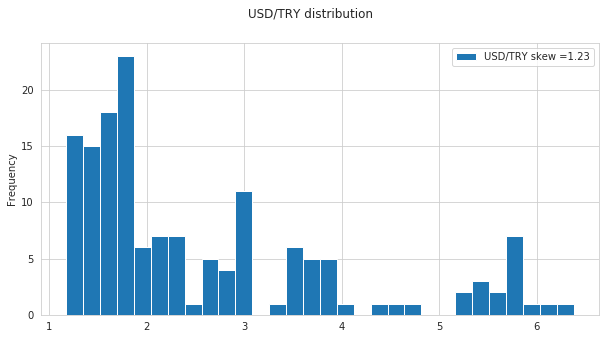

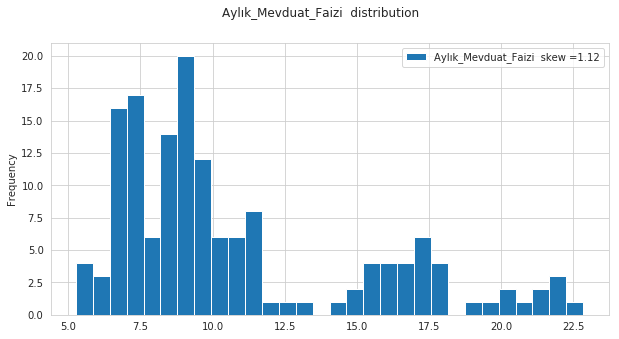

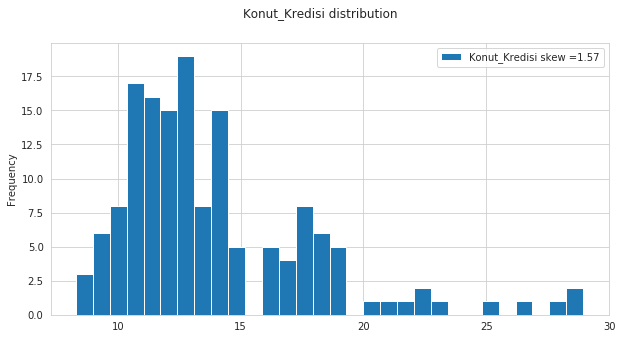

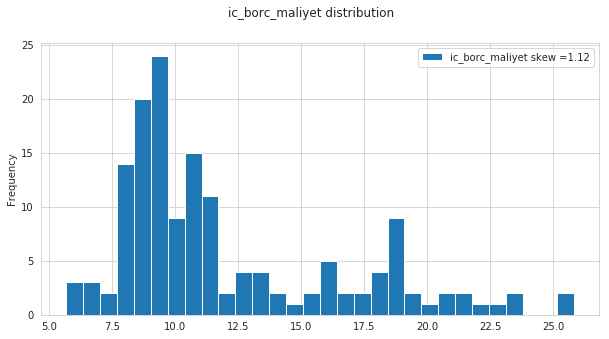

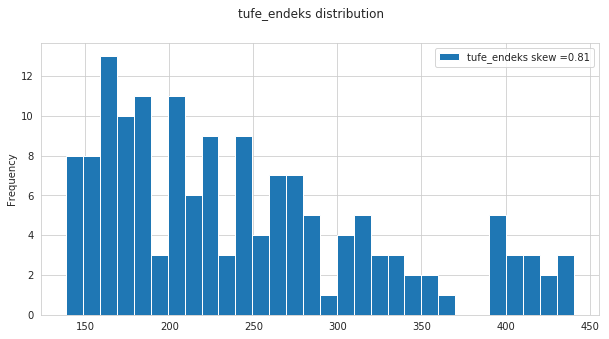

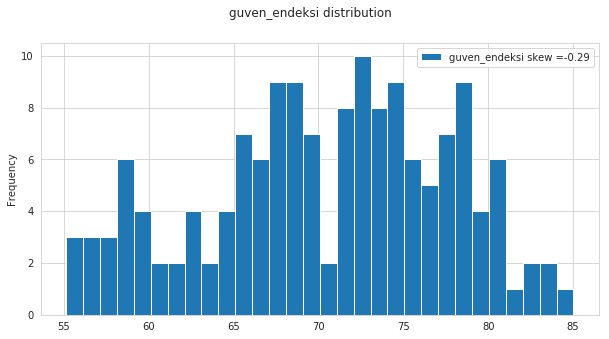

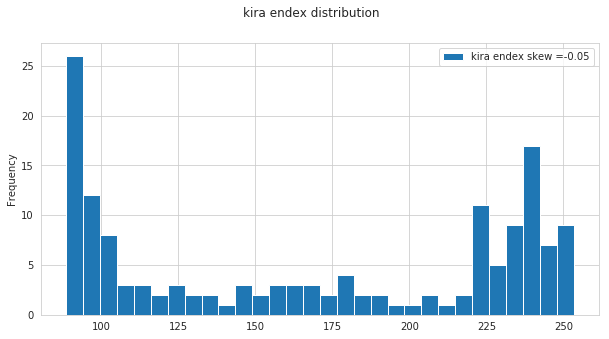

In [15]:
#Check the skewness of HouseEndeks
for col in cols_list:
    plt.figure(figsize=(10, 5))
    skewness = df_train[col].skew()
    df_train[col].plot.hist(edgecolor='white', bins=30, 
                                    label=col + ' skew =' + str(round(skewness,2)))
    plt.suptitle("{} distribution".format(col))
    plt.legend()
    plt.show()

# Box plots

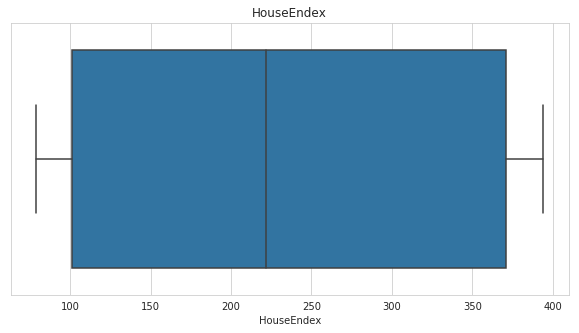

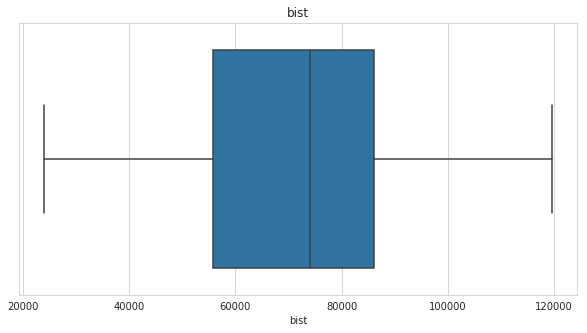

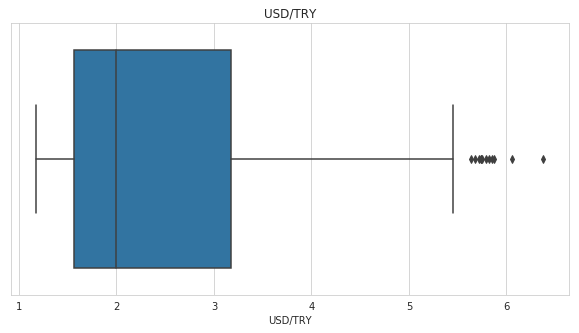

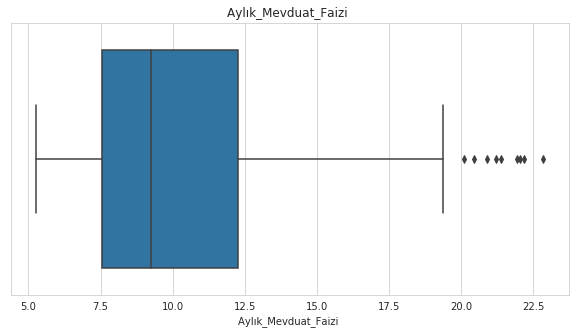

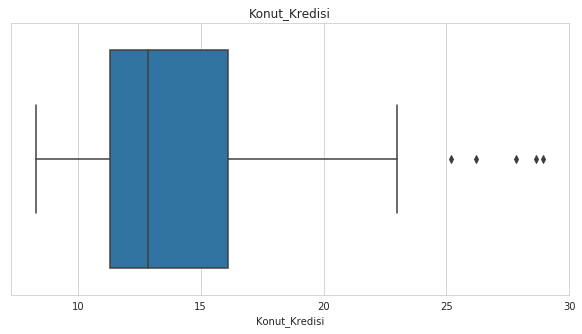

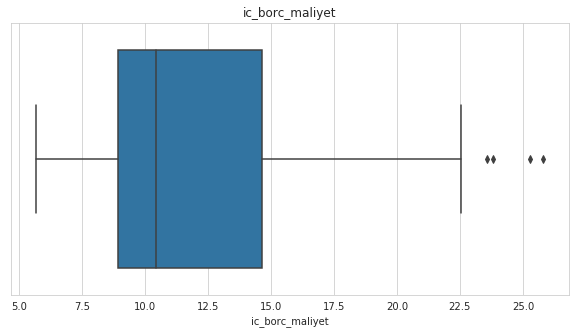

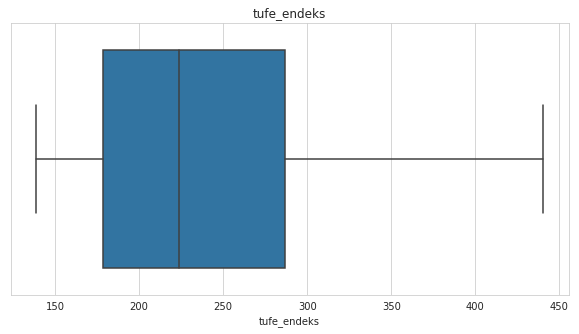

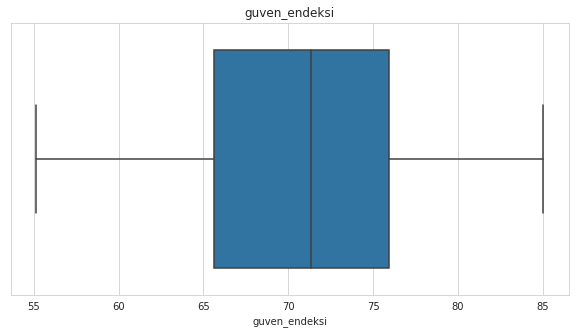

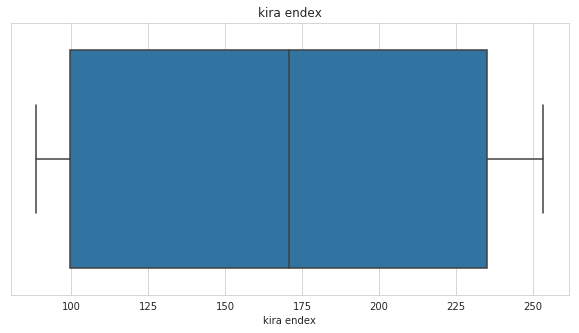

In [16]:
for col in cols_list:
    plt.figure(figsize=(10, 5))
    # Create the boxplot
    ax = sns.boxplot(x=col, data=df_train)
    # Set the `xlim`
    #ax.set(xlim=(0, 100))
    # Add title
    ax.set_title(col)
    # Show the plot
    plt.show()

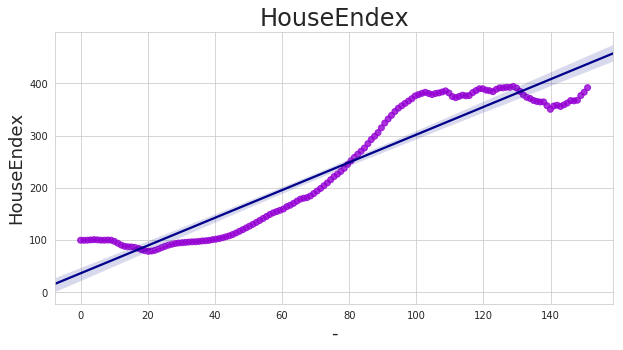

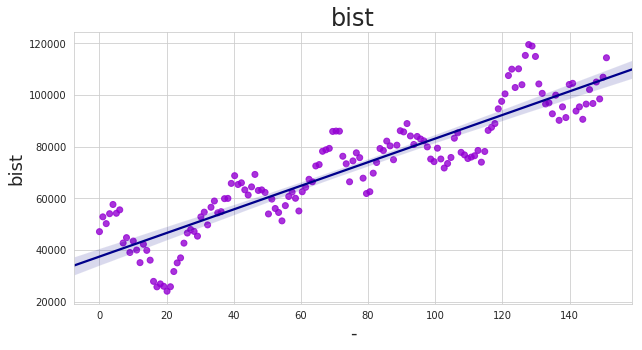

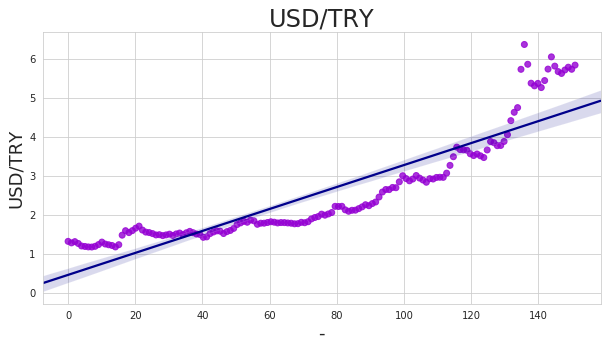

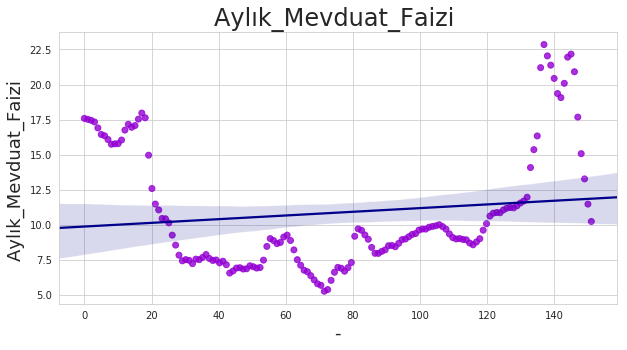

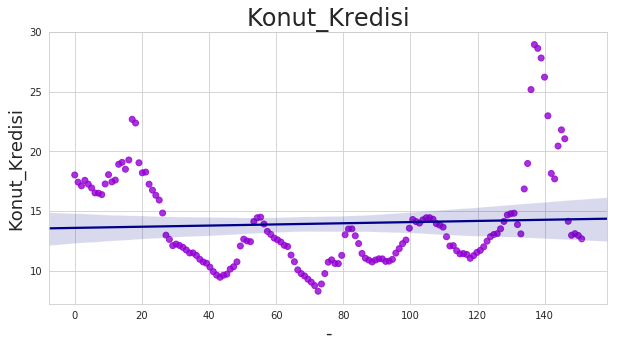

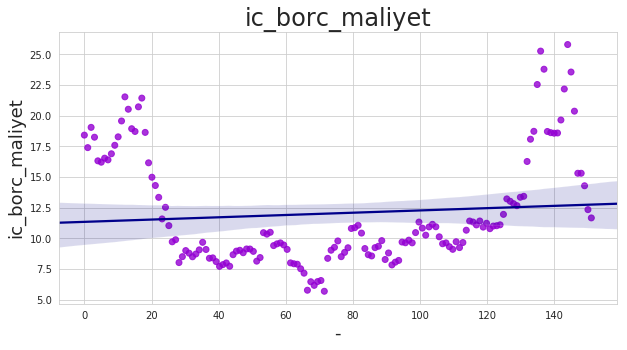

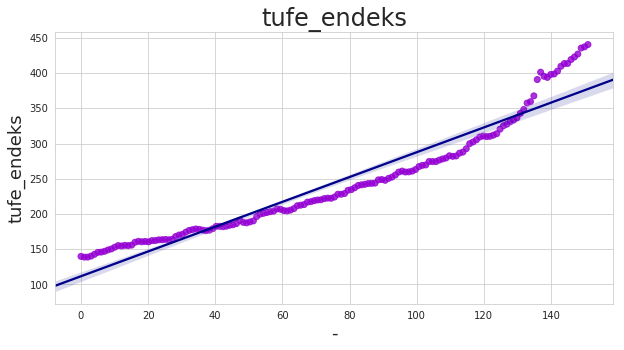

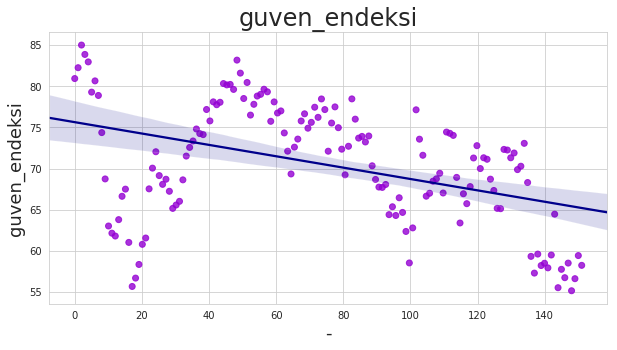

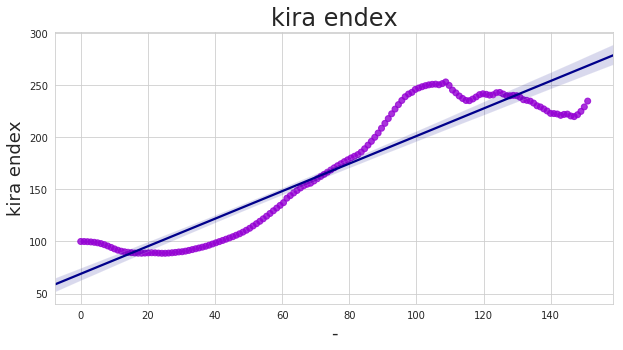

In [17]:
for col in cols_list:    
    y_axis = col
    count = df_train[y_axis].count()
    value=df_train[y_axis]

    plt.figure(figsize=(10, 5))
    sns.regplot(np.linspace(0, count, count), df_train[y_axis], fit_reg=True,
                scatter_kws={'facecolors':np.where( value==True , "red", 'darkviolet'),
               'edgecolor':np.where(value==True , "red", 'darkviolet')},
               line_kws = {'color': 'darkblue'})
    plt.title(col, fontsize=24)
    plt.xlabel('-', fontsize=18)
    plt.ylabel(col, fontsize=18)
    # plt.savefig('figures/Standardised_SalePrice_GrLivArea.png')


# HouseEndex vs other

- Kirmizi: bubble fiyatlari iceren regresyon cizgi
- Mavi: bubble fiyatlari iceren regresyon cizgi

mavi ve kirmizi cizgi arasinda buyuk bir fark varsa, bubble/anomaly mi demek?

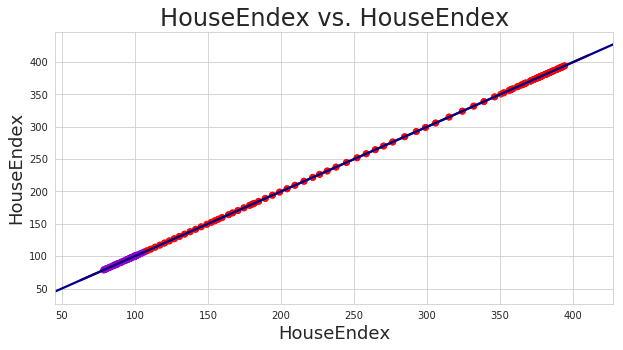

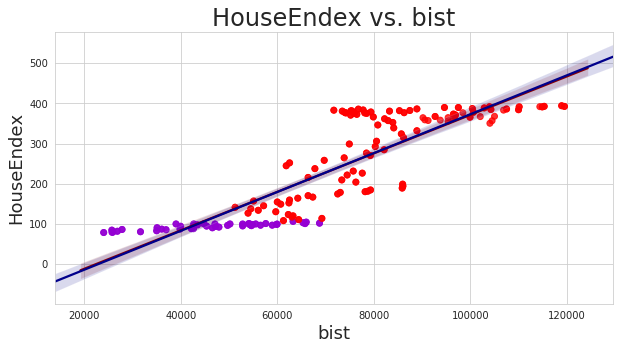

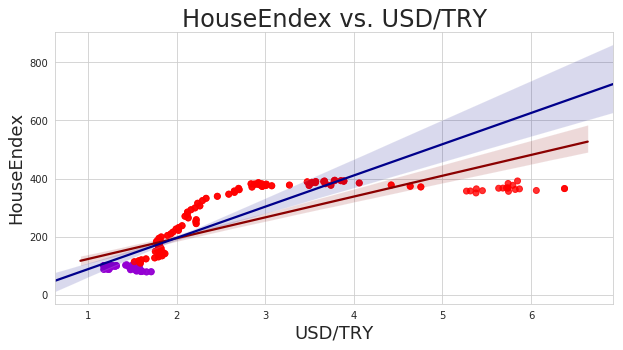

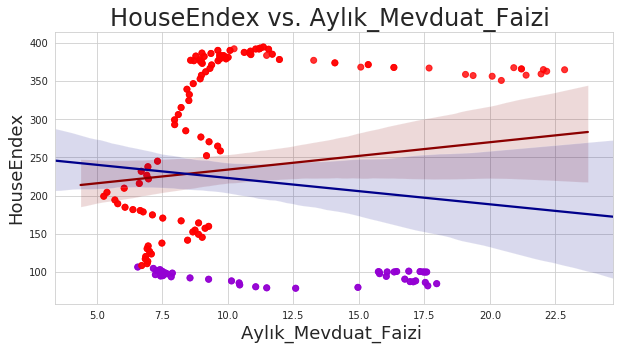

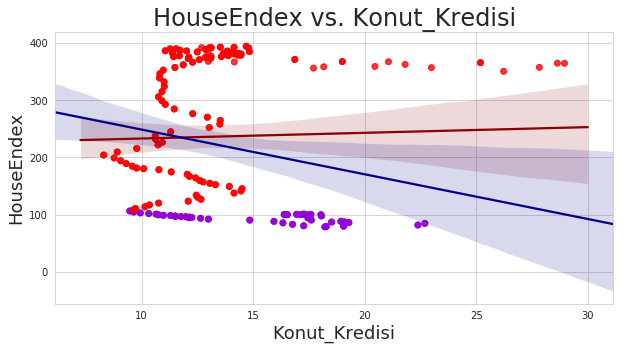

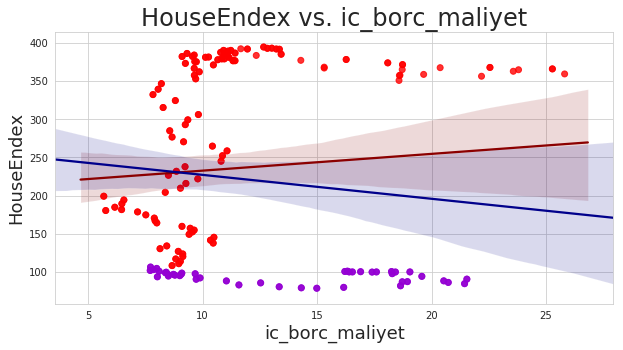

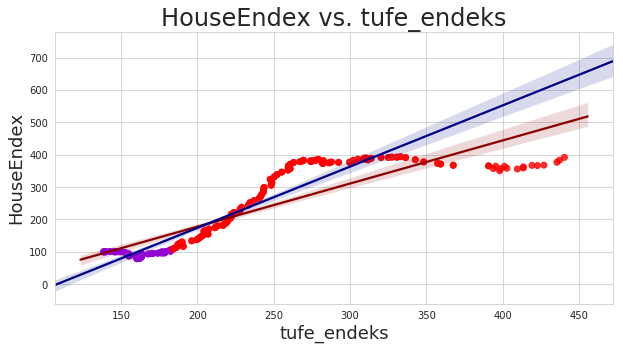

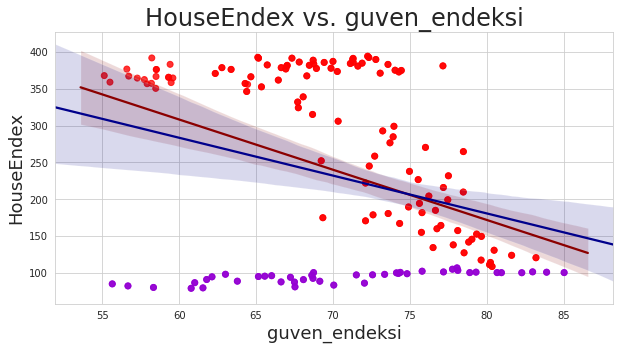

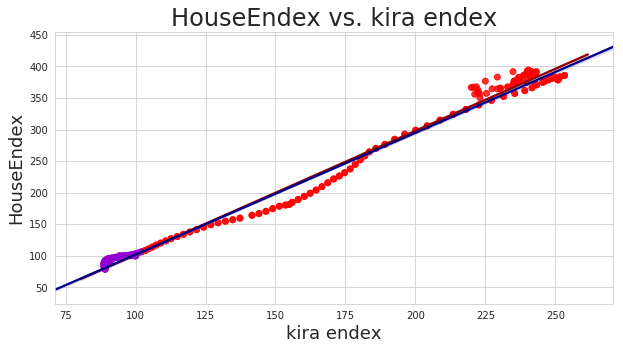

In [18]:
# Displays A Scatter Plot with Regression Line + Outliers in Red

for col in cols_list:
    x_axis = col
    y_axis = 'HouseEndex'
    value=(df_train[y_axis] > 107)
    value2=(df_train[y_axis][:-15] > 107)

    plt.figure(figsize=(10, 5))
    sns.regplot(df_train[x_axis], df_train[y_axis], fit_reg=True,
                scatter_kws={'facecolors':np.where( value==True , "red", 'darkviolet'),
               'edgecolor':np.where(value==True , "red", 'darkviolet')},
               line_kws = {'color': 'darkred'})
    
    sns.regplot(df_train[x_axis][:-15], df_train[y_axis][:-15], fit_reg=True,
                scatter_kws={'facecolors':np.where( value2==True , "red", 'darkviolet'),
               'edgecolor':np.where(value2==True , "red", 'darkviolet')},
               line_kws = {'color': 'darkblue'})
    
    plt.title('HouseEndex vs. {}'.format(x_axis), fontsize=24)
    plt.xlabel(x_axis, fontsize=18)
    plt.ylabel('HouseEndex', fontsize=18)
    # plt.savefig('figures/Standardised_SalePrice_GrLivArea.png')


# XGBoost

hiç faydası yok bu konuda, eğitimde kullandığımız verileri göre sonuç veriyor, ama şişik olup olmadığını gösteremez

In [19]:
#y_full = df_train['HouseEndex']
#X_full = df_train.drop(columns=["HouseEndex"])

y_full = df_train['HouseEndex'][:-15]
X_full = df_train.drop(columns=["HouseEndex"])[:-15]

y_test = df_train['HouseEndex'][-15:]
X_test = df_train.drop(columns=["HouseEndex"])[-15:]

X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=123)

In [20]:
# final model with tuned parameters
model = XGBRegressor(max_depth=6, #dflt 6
                     learning_rate=0.1, #dflt 100
                     n_estimators=1000, #dflt 0.1
                     verbosity = 3,
                     objective='reg:linear',
                     n_jobs=-1,
                     gamma=0, #dflt: 0
                     min_child_weight=3, #0 dflt: 1
                     subsample=0.5,
                     colsample_bytree=1,
                     reg_lambda=0.99994, #dflt: 1
                     reg_alpha=0.00003, #dflt: 0
                     tree_method='exact',
                     scale_pos_weight=1, # dflt: 1
                     random_state=123)

In [21]:
tick=time.time()

fitted_model = model.fit(X_train, y_train,
                         eval_set=[(X_val, y_val)],
                         eval_metric='rmse', # Equivalent to RMSLE since we have log1p(SalePrice)
                         early_stopping_rounds=1000,
                         verbose=True)

print("Duration: {}s".format(time.time()-tick))

[21:36:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-rmse:230.06
Will train until validation_0-rmse hasn't improved in 1000 rounds.
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-rmse:208.91
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-rmse:189.771
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/up

[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[37]	validation_0-rmse:10.3502


/home/ipcvlab/anaconda2/envs/data_science/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[38]	validation_0-rmse:9.84315
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[39]	validation_0-rmse:9.56215
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[40]	validation_0-rmse:9.07446
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[41]	validation_0-rmse:8.68659
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pr

[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[76]	validation_0-rmse:5.19323
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[77]	validation_0-rmse:5.14851
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[78]	validation_0-rmse:5.11212
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[79]	validation_0-rmse:5.08801
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pr

[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[114]	validation_0-rmse:4.94413
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[115]	validation_0-rmse:4.93805
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[116]	validation_0-rmse:4.94636
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[117]	validation_0-rmse:4.94901
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[151]	validation_0-rmse:4.85356
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[152]	validation_0-rmse:4.85133
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[153]	validation_0-rmse:4.8468
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[154]	validation_0-rmse:4.84571
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[189]	validation_0-rmse:4.87373
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[190]	validation_0-rmse:4.88955
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[191]	validation_0-rmse:4.88642
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[192]	validation_0-rmse:4.88277
[21:36:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[227]	validation_0-rmse:4.88625
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[228]	validation_0-rmse:4.88739
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[229]	validation_0-rmse:4.88383
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[230]	validation_0-rmse:4.88564
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[265]	validation_0-rmse:4.88393
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[266]	validation_0-rmse:4.88364
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[267]	validation_0-rmse:4.88185
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[268]	validation_0-rmse:4.88019
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[303]	validation_0-rmse:4.88547
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[304]	validation_0-rmse:4.88509
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[305]	validation_0-rmse:4.88644
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[306]	validation_0-rmse:4.8857
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[341]	validation_0-rmse:4.88074
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[342]	validation_0-rmse:4.88065
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[343]	validation_0-rmse:4.87894
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[344]	validation_0-rmse:4.87987
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[379]	validation_0-rmse:4.88091
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[380]	validation_0-rmse:4.88092
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[381]	validation_0-rmse:4.88222
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[382]	validation_0-rmse:4.88257
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[417]	validation_0-rmse:4.88423
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[418]	validation_0-rmse:4.88471
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[419]	validation_0-rmse:4.8849
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[420]	validation_0-rmse:4.88555
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[455]	validation_0-rmse:4.88849
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[456]	validation_0-rmse:4.88832
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[457]	validation_0-rmse:4.88828
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[458]	validation_0-rmse:4.88808
[21:36:18] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[493]	validation_0-rmse:4.88886
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[494]	validation_0-rmse:4.88879
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[495]	validation_0-rmse:4.8891
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[496]	validation_0-rmse:4.88965
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[531]	validation_0-rmse:4.89013
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[532]	validation_0-rmse:4.89059
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[533]	validation_0-rmse:4.89084
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[534]	validation_0-rmse:4.89142
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[569]	validation_0-rmse:4.89132
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[570]	validation_0-rmse:4.89121
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[571]	validation_0-rmse:4.89122
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[572]	validation_0-rmse:4.89115
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[606]	validation_0-rmse:4.89254
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[607]	validation_0-rmse:4.89251
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[608]	validation_0-rmse:4.8927
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[609]	validation_0-rmse:4.89261
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[644]	validation_0-rmse:4.89227
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[645]	validation_0-rmse:4.89232
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[646]	validation_0-rmse:4.89242
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[647]	validation_0-rmse:4.89246
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[682]	validation_0-rmse:4.89237
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[683]	validation_0-rmse:4.89243
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[684]	validation_0-rmse:4.89241
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[685]	validation_0-rmse:4.89244
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[720]	validation_0-rmse:4.89267
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[721]	validation_0-rmse:4.89271
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[722]	validation_0-rmse:4.89271
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[723]	validation_0-rmse:4.89271
[21:36:19] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[758]	validation_0-rmse:4.89257
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[759]	validation_0-rmse:4.8925
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[760]	validation_0-rmse:4.89249
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[761]	validation_0-rmse:4.8925
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree 

[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[795]	validation_0-rmse:4.89239
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[796]	validation_0-rmse:4.89241
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[797]	validation_0-rmse:4.89242
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[798]	validation_0-rmse:4.89243
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[833]	validation_0-rmse:4.89248
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[834]	validation_0-rmse:4.89243
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[835]	validation_0-rmse:4.8924
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[836]	validation_0-rmse:4.89246
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree 

[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[870]	validation_0-rmse:4.89253
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[871]	validation_0-rmse:4.89255
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[872]	validation_0-rmse:4.89255
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[873]	validation_0-rmse:4.89255
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pr

[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[908]	validation_0-rmse:4.89259
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[909]	validation_0-rmse:4.89259
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[910]	validation_0-rmse:4.89261
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[911]	validation_0-rmse:4.8926
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pr

[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[945]	validation_0-rmse:4.89258
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[946]	validation_0-rmse:4.89258
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[947]	validation_0-rmse:4.89255
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[948]	validation_0-rmse:4.89257
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pr

[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[983]	validation_0-rmse:4.8926
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[984]	validation_0-rmse:4.8926
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[985]	validation_0-rmse:4.89258
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[986]	validation_0-rmse:4.89258
[21:36:20] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pru

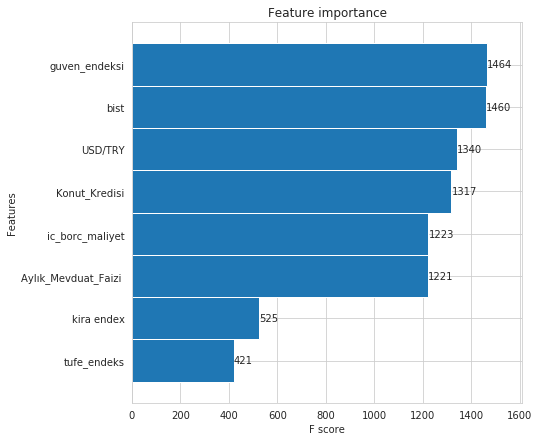

In [22]:
# Plot feature importance
figsize=(7,7)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_importance(model, ax=ax,height = 1)


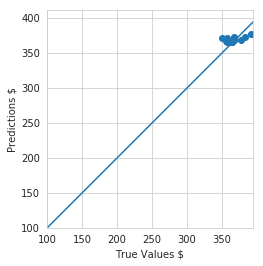

In [23]:
# predict sales in test dataset
test_predictions = model.predict(X_test).flatten()

# scatter plot of True vs Predicted values
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values $')
plt.ylabel('Predictions $')
plt.axis('equal')
plt.axis('square')
plt.xlim([100,plt.xlim()[1]])
plt.ylim([100,plt.ylim()[1]])
_ = plt.plot([0, 1000], [0, 1000])

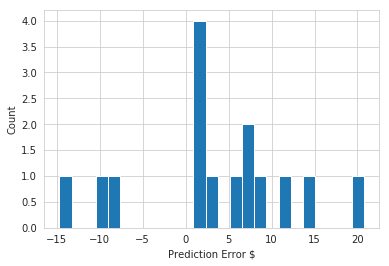

In [24]:
# Histogram of error values
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error $")
_ = plt.ylabel("Count")

# Anomaly detection approach

Loss > Threshold ise = anomaly > bubble mi demek?

In [25]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(df_train[:-14]) # Healthy/normal data
X_test = scaler.fit_transform(df_train[-14:]) # Unhealthy/anomaly data

In [26]:
X_train.shape

(137, 9)

In [27]:
# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [28]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [29]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 9)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1664      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time

In [30]:
history = model.fit(X_train, X_train, epochs=100, batch_size=10,
                    validation_split=0.05).history

Train on 130 samples, validate on 7 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
130/130 [==============================] - 5s 40ms/sample - loss: 0.3405 - val_loss: 0.7008
Epoch 2/100
130/130 [==============================] - 0s 3ms/sample - loss: 0.3258 - val_loss: 0.6842
Epoch 3/100
130/130 [==============================] - 0s 1ms/sample - loss: 0.3112 - val_loss: 0.6665
Epoch 4/100
130/130 [==============================] - 0s 2ms/sample - loss: 0.2965 - val_loss: 0.6475
Epoch 5/100
130/130 [==============================] - 0s 2ms/sample - loss: 0.2817 - val_loss: 0.6276
Epoch 6/100
130/130 [==============================] - 0s 1ms/sample - loss: 0.2671 - val_loss: 0.6062
Epoch 7/100
130/130 [==============================] - 0s 2ms/sample - loss: 0.2538 - val_loss: 0.5835
Epoch 8/100
130/130 [==============================] - 0s 1ms/sample - loss: 0.2417 - val_loss: 0.5580
Epoch 9/100
130/130 [==============================] - 0s 1ms/sample - loss: 0.2308

130/130 [==============================] - 0s 2ms/sample - loss: 0.0782 - val_loss: 0.2279
Epoch 77/100
130/130 [==============================] - 0s 2ms/sample - loss: 0.0779 - val_loss: 0.2292
Epoch 78/100
130/130 [==============================] - 0s 2ms/sample - loss: 0.0778 - val_loss: 0.2317
Epoch 79/100
130/130 [==============================] - 0s 1ms/sample - loss: 0.0773 - val_loss: 0.2258
Epoch 80/100
130/130 [==============================] - 0s 1ms/sample - loss: 0.0770 - val_loss: 0.2220
Epoch 81/100
130/130 [==============================] - 0s 1ms/sample - loss: 0.0769 - val_loss: 0.2234
Epoch 82/100
130/130 [==============================] - 0s 1ms/sample - loss: 0.0769 - val_loss: 0.2234
Epoch 83/100
130/130 [==============================] - 0s 1ms/sample - loss: 0.0765 - val_loss: 0.2218
Epoch 84/100
130/130 [==============================] - 0s 1ms/sample - loss: 0.0766 - val_loss: 0.2248
Epoch 85/100
130/130 [==============================] - 0s 3ms/sample - loss:

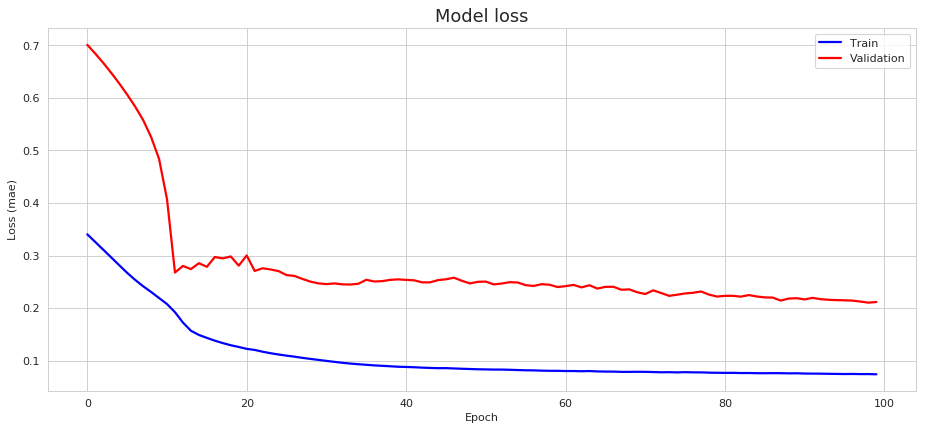

In [31]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

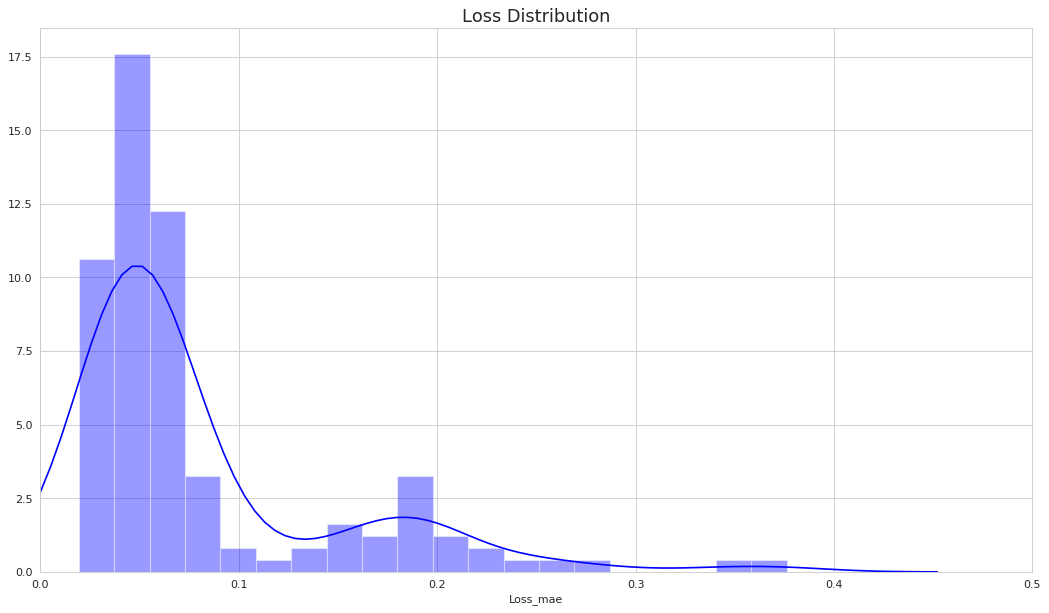

In [32]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train[:-14].index

scored = pd.DataFrame(index=df_train[:-14].index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

#Out[17]:
#(0.0, 0.5)

In [33]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train[-14:].index

scored = pd.DataFrame(index=df_train[-14:].index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.2
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
Tarih,,,
2018-11,0.314483,0.2,True
2018-12,0.320154,0.2,True
2019-01,0.278746,0.2,True
2019-02,0.241173,0.2,True
2019-03,0.192568,0.2,False


In [34]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=df_train[:-14].columns)
X_pred_train.index = df_train[:-14].index

scored_train = pd.DataFrame(index=df_train[:-14].index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.2
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])
scored
scored.to_csv("/home/ipcvlab/Desktop/output.csv")

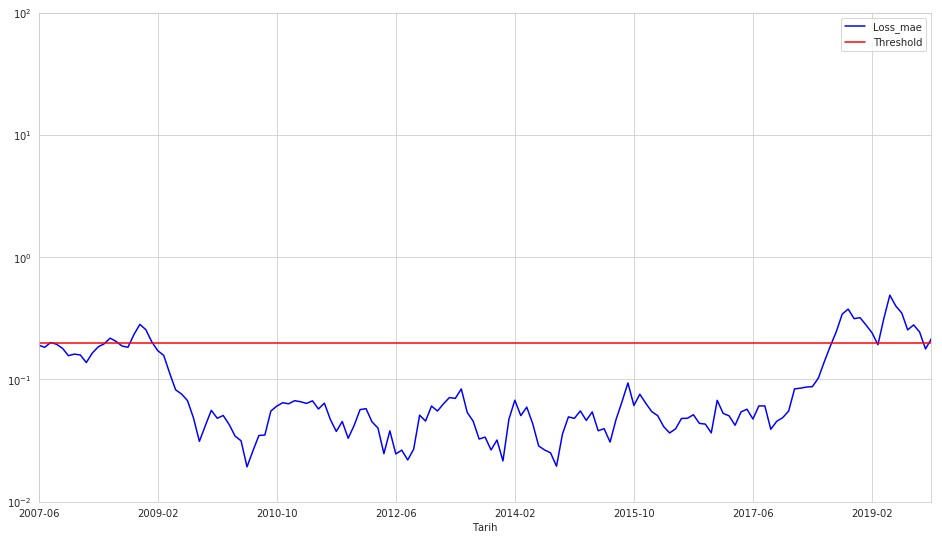

In [35]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])